In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os
import tqdm
import glob
import tensorflow

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from skimage.io import imread, imshow
from skimage.transform import resize
#from skimage.color import grey2rgb

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.densenet import DenseNet169
from keras.preprocessing.image import load_img, img_to_array

# Dataset: https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range=10,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   validation_split = 0.2)

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255)

In [3]:
train_dataset  = train_datagen.flow_from_directory(directory = 'D:/alzhiemer/Alzheimer_s Dataset/train',
                                                   target_size = (224,224),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 32)

Found 4098 images belonging to 4 classes.


In [4]:
valid_dataset = valid_datagen.flow_from_directory(directory = 'D:/alzhiemer/Alzheimer_s Dataset/train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 32)

Found 1023 images belonging to 4 classes.


In [5]:
# Model Initialization

base_model = DenseNet169(input_shape=(224,224,3), 
                         include_top=False,
                         weights="imagenet")

In [6]:
# Freezing Layers

for layer in base_model.layers:
    layer.trainable=False

In [7]:
model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 dropout (Dropout)           (None, 7, 7, 1664)        0         
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 batch_normalization (Batch  (None, 81536)             326144    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1024)              83493888  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                        

In [11]:
from keras.optimizers import Adam
OPT = Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=OPT)

In [12]:
# Defining Callbacks
filepath = './best_weights.h5'

earlystopping = EarlyStopping(monitor='val_accuracy',
                              mode='max',
                              patience=15,
                              verbose=1)

checkpoint = ModelCheckpoint(filepath,
                              monitor='val_accuracy',
                              mode='max',
                              save_best_only=True,
                              verbose=1)

callback_list = [earlystopping, checkpoint]

In [17]:
model_history=model.fit(train_dataset,
                        validation_data=valid_dataset,
                        epochs = 25,
                        callbacks = callback_list,
                        verbose = 1)


Epoch 1/25
129/129 [==============================] - ETA: 0s - loss: 0.3763 - accuracy: 0.8590
Epoch 1: val_accuracy improved from 0.63832 to 0.65494, saving model to .\best_weights.h5
129/129 [==============================] - 403s 3s/step - loss: 0.3763 - accuracy: 0.8590 - val_loss: 1.0523 - val_accuracy: 0.6549
Epoch 2/25
129/129 [==============================] - ETA: 0s - loss: 0.3753 - accuracy: 0.8594
Epoch 2: val_accuracy did not improve from 0.65494
129/129 [==============================] - 400s 3s/step - loss: 0.3753 - accuracy: 0.8594 - val_loss: 1.2047 - val_accuracy: 0.6354
Epoch 3/25
129/129 [==============================] - ETA: 0s - loss: 0.3284 - accuracy: 0.8797
Epoch 3: val_accuracy improved from 0.65494 to 0.68622, saving model to .\best_weights.h5
129/129 [==============================] - 384s 3s/step - loss: 0.3284 - accuracy: 0.8797 - val_loss: 1.0664 - val_accuracy: 0.6862
Epoch 4/25
129/129 [==============================] - ETA: 0s - loss: 0.3498 - accura

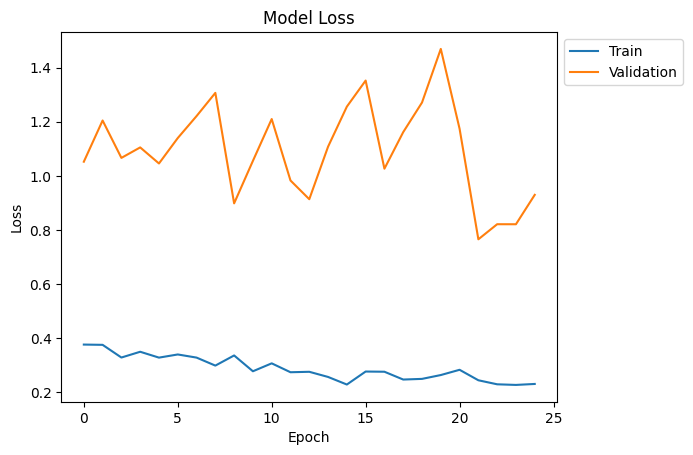

In [18]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [19]:
# Summarize history for loss

plt.plot(model_history.history['auc'])
plt.plot(model_history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

KeyError: 'auc'

In [20]:
test_dataset = test_datagen.flow_from_directory(
    directory='D:/alzhiemer/Alzheimer_s Dataset/test',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=128
)

test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')


Found 1279 images belonging to 4 classes.
10/10 [==============================] - 45s 4s/step - loss: 1.8901 - accuracy: 0.7334
Test Loss: 1.8901, Test Accuracy: 73.34%


In [21]:
# Saving a TensorFlow model
model.save('my_model.h5') 